#  REGRESSION LOGISTIQUE

# Introduction

Dans cet exercice guid√© nous allons pratiquer la r√©gression logistique sous Python via les packages ¬´ statsmodels ¬ª et ¬´ scikit-learn ¬ª.

Nous t√¢cherons de d√©crire les diff√©rentes √©tapes de la construction du mod√®le √† son √©valuation et la mesure de ses performances pr√©dictives.

# A. Utilisation du package scikit-learn

## 1. Import des librairies


Pour commencer nous allons utiliser uniquement le packages scikit-learn
hormis les librairies classiques importez celle utilis√©e pour la regression logistique et celles pour les m√©triques necessaires (matrice de confusion, rapport des m√©triques)



In [109]:
# librairies classiques
import pandas as pd
import numpy as np

# packages scikit-learn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
print(sklearn.__version__)

# packages visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

1.0.1


## 2. Import du dataset


Nous analysons dans cet exercice les facteurs de risque d'infid√©lit√© dans les m√©nages. 

Nous verrons que le facteur temps est bien √©videmment un param√®tre qui joue en faveur de l'infid√©lit√©. 

Mais pas seulement, d'autres variables √©galement.

In [88]:
# importation du dataset
dataset = pd.read_excel('./data/dataset_infidelites.xlsx')

# visualisation du jeu de donn√©es
dataset.head()

Sex   Age  YearsMarried  Children  Religious  Education  Occupation  \
0    0  22.0          0.75         0          2         18           6   
1    0  32.0         15.00         1          3         14           1   
2    1  27.0          4.00         1          4         20           5   
3    0  22.0          1.50         0          2         16           4   
4    0  27.0          7.00         1          3         14           1   

   RatingMarriage  Infidelite  
0               5           0  
1               2           1  
2               5           0  
3               5           0  
4               4           0

## 3. Description et visualisation du dataset

### 3.1 Description rapide du dataset

In [89]:
# description rapide du jeu de donn√©es
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             601 non-null    int64  
 1   Age             601 non-null    float64
 2   YearsMarried    601 non-null    float64
 3   Children        601 non-null    int64  
 4   Religious       601 non-null    int64  
 5   Education       601 non-null    int64  
 6   Occupation      601 non-null    int64  
 7   RatingMarriage  601 non-null    int64  
 8   Infidelite      601 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 42.4 KB


**Ce que je constate :**

- Dataset de 601 entr√©es et 9 colonnes dont index.

- Donn√©es de type numerique : float et integer.

- Aucune donn√©es manquantes ou nulles.

In [90]:
for column in dataset.columns:
    print(column, dataset[column].nunique())

Sex 2
Age 9
YearsMarried 8
Children 2
Religious 5
Education 7
Occupation 7
RatingMarriage 5
Infidelite 2


**Ce que je constate :**

Les donn√©es du dataset concernent des individus mari√©s en donnant des indications sur :

- leur genre (0/1), 
- leur age, 
- le nombre d'ann√©es de mariage, 
- si ils ont des enfants (0/1), 
- leur appartenance religieuse, 
- leur nombre d'ann√©es d'√©ducation, 
- leur cat√©gorie d'emploi, 
- le niveau d'√©valuation de leur mariage,
- si ils ont √©t√© infid√®les (0/1).

### 3.2 Br√®ve analyse exploratoire

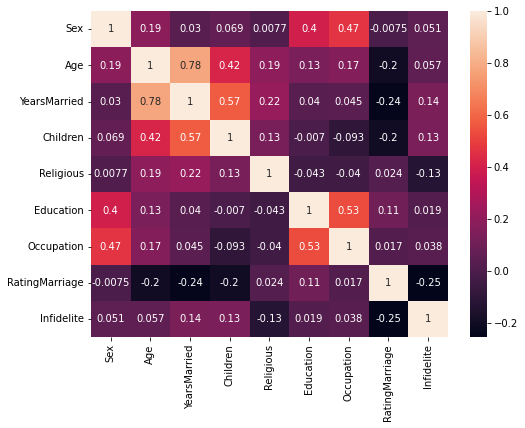

In [91]:
# Affichage de la matrice de correlation
mat_corr = dataset.corr()

# en utilisant matplotlib
#plt.matshow(mat_corr)

# en utilisant seaborn
plt.figure(figsize=(8,6))
sns.heatmap(mat_corr, annot=True) # avec seaborn
plt.show()

#print(mat_corr)

In [92]:
# en visualisant les variables les plus pertinentes
# A premi√®res vues, qu'en d√©duisez vous ? 

**Ce que je peux d√©duire :**

La matrice de corr√©lation permet d'√©valuer l'importance et la direction de la relation entre deux variables. Une valeur de corr√©lation positive √©lev√©e indique que les variables mesurent la m√™me caract√©ristique. Si les items ne sont pas fortement corr√©l√©s, ils peuvent mesurer des caract√©ristiques diff√©rentes ou ne pas √™tre clairement d√©finis.

- Certaines paires de variables telles que "Age/YearsMarried", "Children/YearsMarried", "Occupation/Education" indiquent une relation positive. On pourrait dire que plus le nombre d'ann√©es de mariage est √©lev√©, plus les valeurs des observations Age et Children sont importantes.

- D'autres posent question, "Infidelite/RatingMarriage", "YearsMarried/RatingMarriage", "Age/RatingMarriage" ou encore "Children/RatingMarriage" en indiquant une relation n√©gative. On pourrait dire que plus la valeur d'√©valuation du marriage est basse, plus les valeurs des observations Age, Children, YearsMarried et Infidelit√© sont importantes.

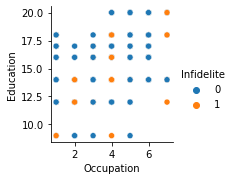

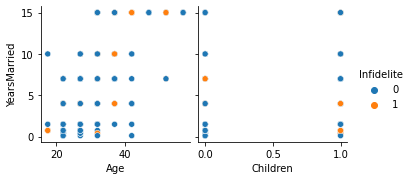

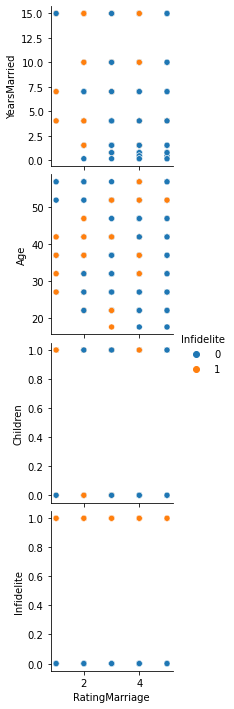

In [93]:
# visualisation plus pr√©cise des variables qui semble le plus pertinentes
sns.pairplot(dataset, x_vars=['Occupation'], y_vars=['Education'], hue='Infidelite')
sns.pairplot(dataset, x_vars=['Age', 'Children'], y_vars=['YearsMarried'], hue='Infidelite')
sns.pairplot(dataset, x_vars=['RatingMarriage'], y_vars=['YearsMarried','Age','Children','Infidelite'], hue='Infidelite')

**Ce que je peux d√©duire :**

- Le nombre d'ann√©es d'education a une relation avec l'occupation, plus le nombre d'ann√©es est important plus la valeur de la variable Occupation est importante. Mais pas de relation pertinente avec l'infid√©lit√©.

- Bien que le nombre d'ann√©es de mariage et l'age soit des variables positivement correl√©es, plus on est ag√© plus le nombre d'ann√©es de mariage est √©lev√©, ces deux variables ne suffisent pas pour √©tablir une relation pertinente avec l'infid√©lit√©. On constate cependant qu'entre 5 et 10 ann√©es de mariage, l'infid√©lit√© est peu ou pas repr√©sent√©e, sauf si il n'y a pas d'enfant. La pr√©sence d'enfant dans un m√©nage de moins de 5 ans semble aussi avoir une importance dans l'infid√©lit√©.

- Il n'y a, √† priori, pas de relation entre la note d'√©valuation du mariage et l'infid√©lit√©. Cependant des variables telles que le nombre d'ann√©es de mariage et l'age semble contrebalancer cette relation. Les individus satisfaits de leur mariage semblent moins infid√®les si ils sont mari√©s entre 3 et 10 ans ou si ils ont entre 30 et 50 ans.

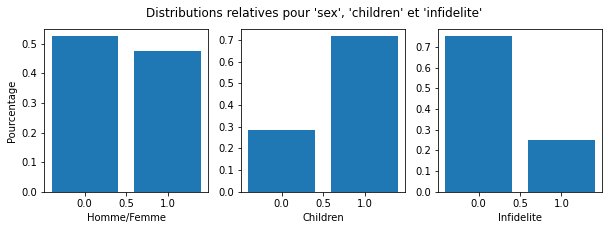

In [94]:
# Distribution relative des cat√©gories 'Sex' et 'Infidelite'
sex = dataset.Sex.value_counts(normalize=True)
indidelite = dataset.Infidelite.value_counts(normalize=True)
children = dataset.Children.value_counts(normalize=True)
religious = dataset.Religious.value_counts(normalize=True)
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.xlabel('Homme/Femme')
plt.ylabel('Pourcentage')
plt.bar(sex.index, sex.values)
plt.subplot(132)
plt.xlabel('Children')
plt.bar(children.index, children.values)
plt.subplot(133)
plt.xlabel('Infidelite')
plt.bar(indidelite.index, indidelite.values)
plt.suptitle("Distributions relatives pour 'sex', 'children' et 'infidelite'")
plt.show()

**Ce que je peux d√©duire :**

Distribution relative du dataset :

- La r√©partition homme/femme est quasiment √©quilibr√©e.

- La majorit√© des individus ont des enfants.

- L'infidelit√© concerne pr√®s de 25% des individus.

<AxesSubplot:title={'center':'Relation Religious et Infidelite'}, xlabel='Religious'>

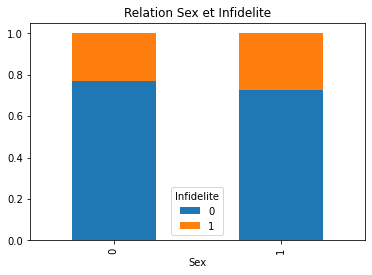

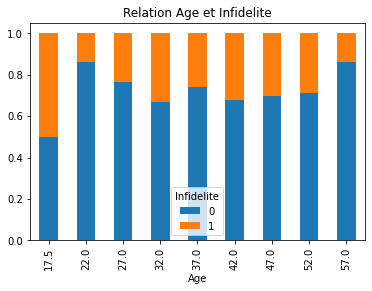

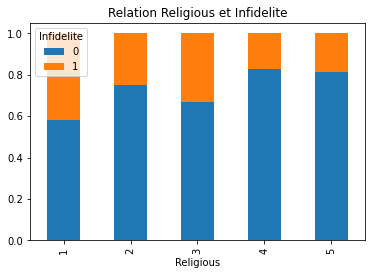

In [95]:
table_sex_infidelite = pd.crosstab(dataset.Sex, dataset.Infidelite)
table_sex_infidelite.div(table_sex_infidelite.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, title="Relation Sex et Infidelite")

table_age_infidelite = pd.crosstab(dataset.Age, dataset.Infidelite)
table_age_infidelite.div(table_age_infidelite.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, title="Relation Age et Infidelite")

table_religon_infidelite = pd.crosstab(dataset.Religious, dataset.Infidelite)
table_religon_infidelite.div(table_religon_infidelite.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, title="Relation Religious et Infidelite")

**Ce que je peux d√©duire :**

- pas plus d'infid√©lit√© chez les hommes que chez les femmes;

- plus d'infidelit√© chez les moins de 20 ans que chez les plus de 50;

- plus d'infid√©lit√© pour chez les individus de cat√©gorie 1 pour la variable Religious;

## 4. S√©paration du dataset en Train set et Test set

 Les variables ind√©pendantes sont celles qui sont manipul√©es (data), tandis que les variables d√©pendantes sont seulement mesur√©es ou enregistr√©es (target). 

In [96]:
# d√©finissez tout d'abord vos variables : ind√©pendantes/ dependante
X = dataset.drop('Infidelite', axis=1)
y = dataset['Infidelite']

In [97]:
# splittez votre dataset de sorte √† avoir 1/3 des donn√©es dans le test set
test_size = 1/3
X_tn, X_tt, y_tn, y_tt = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)

In [107]:
# v√©rifiez le nombre de donn√©es y dans chaque jeu (train et test)
print('Nombre de donn√©es y : Train :',y_tn.shape,'; Test :', y_tt.shape)
print('Stratification par y : Train :', y_tn.mean(), '; Test :', y_tt.mean())

Nombre de donn√©es y : Train : (400,) ; Test : (201,)
Stratification par y : Train : 0.25 ; Test : 0.24875621890547264


**train_test_split() parameters :**

- random_state (int, RandomState instance or None), default=None : Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. See Glossary.

- shuffle (bool), default=True : Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

- stratify (array-like), default=None : If not None, data is split in a stratified fashion, using this as the class labels

## .5. Entrainement de la regression logistique sur le Train set

In [110]:
# Nous instancions une r√©gression logistique sans p√©nalit√© c.-√†-d. sans r√©aliser de r√©gularisation pour l'instant
lr = LogisticRegression(penalty='none')
# lancement de l‚Äôestimation des donn√©es de training
lr.fit(X_tn, y_tn)

C:\Users\odazo\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none')

**Que se passe t - il ?**

Le processus n‚Äôa pas converg√© alors que le nombre maximal d‚Äôit√©ration par d√©faut est (max_iter = 100).(voir doc)

¬´ Scikit-learn ¬ª nous propose alors de :

- soit augmenter le nombre d‚Äôit√©rations (mais trop de puissance de calcul pour un r√©sultat incertain),

- soit de standardiser les donn√©es avant de lancer l‚Äôalgorithme.

La documentation de la r√©gression logistique sous ¬´ scikit-learn ¬ª nous indique les diff√©rents algorithmes d‚Äôoptimisation qu‚Äôil est susceptible d‚Äôutiliser (option ¬´ solver ¬ª).

Ces approches sont sensibles aux diff√©rences d‚Äô√©chelles entre les variables, d‚Äôo√π l‚Äôindication ¬´ scale the data ¬ª dans le
¬´ warning ¬ª envoy√© par la m√©thode fit()

In [112]:
print(pd.DataFrame({"Variable": X_tn.columns, "Coeff.": lr.coef_[0]}))

         Variable    Coeff.
0             Sex  0.322867
1             Age -0.037457
2    YearsMarried  0.067207
3        Children  0.479657
4       Religious -0.242763
5       Education  0.042252
6      Occupation -0.034653
7  RatingMarriage -0.600989


### Standardisation des donn√©es

La doc de la r√©gression logistique sous ¬´ scikit-learn ¬ª nous indique les diff√©rents algorithmes d‚Äôoptimisation qu‚Äôil est susceptible d‚Äôutiliser (option ¬´ solver ¬ª).

Ces approches sont sensibles aux diff√©rences d‚Äô√©chelles entre les variables, d‚Äôo√π l‚Äôindication ¬´ scale the data ¬ª dans le ¬´ warning ¬ª envoy√© par la m√©thode fit().

Nous allons donc centrer et r√©duire nos donn√©es avant de relancer le mod√®le

In [100]:
#importation de la biblioth√®que necessaire √† la standardisation
from sklearn import preprocessing
import scipy as sci
#instanciation
scaler = preprocessing.StandardScaler()
scaler.fit(X_tn)
#transformation
X_tn_scaled = scaler.transform(X_tn)
X_tn_scaled = pd.DataFrame(X_tn_scaled, index=X_tn.index, columns=X_tn.columns)
X_tt_scaled = scaler.transform(X_tt)
X_tt_scaled = pd.DataFrame(X_tt_scaled, index=X_tt.index, columns=X_tt.columns)


In [101]:
# imprimer les statistiques de descriptions
X_tn_scaled.mean()
# remarquez que les variables sont bien de moyenne nulle et d‚Äô√©cart-type unitaire.

Sex              -3.885781e-17
Age               1.820766e-16
YearsMarried      8.659740e-17
Children          1.354472e-16
Religious        -1.398881e-16
Education        -5.018208e-16
Occupation       -2.087219e-16
RatingMarriage    4.440892e-17
dtype: float64

In [102]:
X_tn_scaled.std()

Sex               1.001252
Age               1.001252
YearsMarried      1.001252
Children          1.001252
Religious         1.001252
Education         1.001252
Occupation        1.001252
RatingMarriage    1.001252
dtype: float64

In [103]:
#quelles sont les valeurs que peuvent prendre y ? essayer avec attribute_classes


### relancez votre mod√®le

In [104]:
# relancez le mod√®le avec les nouvelles valeurs standardis√©es

#affichez les coefficients

### D√©-standardisation des coefficients

ATTENTION ! nous travaillons sur des donn√©es transform√©es. Nous devons les ¬´ d√©-standardiser ¬ª en les divisant par les √©carts-type des variables.


In [105]:
#correction des coefficients -
#  d√©-standardisationpar les √©carts-type utilis√©s lors de la standardisation des variables
coefUnstd = classifier_std.coef_[0] / stds.scale_

#affichage des coefficients corrig√©s


NameError: name 'classifier_std' is not defined

In [ ]:
# on fait de m√™me pour la constante (l'ordonn√©e √† l'origine)
interceptUnStd =classifier_std.intercept_ + np.sum(classifier_std.coef_[0]*(-stds.mean_/stds.scale_))
print(interceptUnStd)


[0.81174835]


## 6. R√©aliser des pr√©dictions sur les r√©sultats du Train set

In [ ]:
# calcul des probabilit√©s d'affectation

# on affiche les 5 premi√®res valeurs pr√©dites


array([[0.83464078, 0.16535922],
       [0.85621929, 0.14378071],
       [0.9265064 , 0.0734936 ],
       [0.70229399, 0.29770601],
       [0.48264007, 0.51735993]])

On observe 2 colonnes : la premi√®re correspond au proba d'appartenir √† Y=0 et la seconde √† Y=1

In [ ]:
#et on les compare aux valeurs attendues


          Y=0       Y=1  valeur attendue
569  0.834641  0.165359                0
167  0.856219  0.143781                0
435  0.926506  0.073494                0
413  0.702294  0.297706                0
344  0.482640  0.517360                1
..        ...       ...              ...
335  0.892892  0.107108                0
305  0.733390  0.266610                1
158  0.863535  0.136465                0
401  0.923431  0.076569                0
583  0.869559  0.130441                1

[401 rows x 3 columns]


## 7. Faites des pr√©dictions des r√©sultats du test set

In [ ]:
# nous devons appliquer la m√™me standardisation sur les valeurs du test set ! 

#transformation de l'√©chantillon test


#stat. descriptives
#print(sci.stats.describe(X1_test,axis=0,ddof=0))

# on applique le mod√®le √† l'√©chantillon




## 8. Evaluation des performances du mod√®le √† l'aide de la matrice de confusion 

In [ ]:
# affichez la matrice de confusion
cm = 
print(cm)

[[144   6]
 [ 41   9]]


- Combien y a t-il de faux positifs ? combien de faux n√©gatifs ?
- Combien d'√©l√©ments sont bien class√©s? 
- repr√©sentez la matrice de confusion sous la forme d'une heatmap

In [ ]:
#affichez le taux d'erreur


0.765


In [ ]:
#affichez le rapport de classification



              precision    recall  f1-score   support

           0       0.78      0.96      0.86       150
           1       0.60      0.18      0.28        50

    accuracy                           0.77       200
   macro avg       0.69      0.57      0.57       200
weighted avg       0.73      0.77      0.71       200



# B. Utilisation de Stats.models

## 1. Import des librairies

In [ ]:
#importez la librairie ad√©quate
import numpy as np
import statsmodels.api as sm
from statsmodels.api import Logit

## 2. Preparation du dataset

In [ ]:
#attention StatsModels ne prend pas en compte l'ordonn√©e √†l'origine ùëè‚ÇÄ! 
# vous devez inclure la colonne suppl√©mentaire de "1" dans x. 
#faites cela avec add_constant ():

from statsmodels.tools import add_constant
#donn√©es X avec la constante

#v√©rifier la structure, vous devez bien avoir une colonne en plus



<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 569 to 583
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   const           401 non-null    float64
 1   Sex             401 non-null    int64  
 2   Age             401 non-null    float64
 3   YearsMarried    401 non-null    float64
 4   Children        401 non-null    int64  
 5   Religious       401 non-null    int64  
 6   Education       401 non-null    int64  
 7   Occupation      401 non-null    int64  
 8   RatingMarriage  401 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 31.3 KB
None


## 3. Entrainement du mod√®le

In [ ]:
# Cr√©ez votre mod√®le de r√©gression logistique 

#lancez les calculs


Optimization terminated successfully.
         Current function value: 0.511723
         Iterations 6


In [ ]:
#pour acc√©der aux valeurs des coefficients, utilisez .params
#Obtenez vous les m√™me r√©sulats que pr√©cedemment? 


const             0.811794
Sex              -0.040367
Age              -0.016375
YearsMarried      0.061595
Children          0.101120
Religious        -0.307265
Education         0.043020
Occupation        0.044014
RatingMarriage   -0.508548
dtype: float64

In [ ]:
# affichez le rapport des metriques avec stat.model. Il est possible d'utiliser .summary() soit .summary2()
#pour plus d'infos : https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.html

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Infidelite   No. Observations:                  401
Model:                          Logit   Df Residuals:                      392
Method:                           MLE   Df Model:                            8
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:                 0.08889
Time:                        21:09:34   Log-Likelihood:                -205.20
converged:                       True   LL-Null:                       -225.22
                                        LLR p-value:                 3.148e-06
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8118      1.040      0.780      0.435      -1.227       2.851
Sex               -0.0404      0.289     -0.140      0.889      -0.607       0.526
Age               -0.0164      0.021     -0.766      0.444      -0.058       0.026
YearsMarried       0.0616      0.039      1.594      0.111      -0.014       0.137
Children           0.1011      0.343      0.295      0.768      -0.570       0.773
Religious         -0.3073      0.107     -2.867      0.004      -0.517      -0.097
Education          0.0430      0.062      0.693      0.488      -0.079       0.165
Occupation         0.0440      0.088      0.498      0.618      -0.129       0.217
RatingMarriage    -0.5085      0.112     -4.547      0.000      -0.728      -0.289
==================================================================================
"""

## 4. R√©aliser des pr√©dictions sur les r√©sultats du Test set

In [ ]:
#affichez les probabilit√©s de pr√©diction


In [ ]:
#utilisez les pour afficher les valeurs de y en ayant √©tabli un seuil √† 0.5


## 5. Evaluation des performances du mod√®le √† l'aide de la matrice de confusion

In [ ]:
#obtenez la matrice de confusion avec crosstable


col_0         0  1
Infidelite        
0           144  6
1            41  9


In [ ]:
#calculez √©galement le taux de reconnaissance et le taux d'erreur  : (taux d'erreur = 1- taux de reconnaissance)


#taux d'erreur


Taux de reconnaissance : 0.765
Taux d'erreur' :  0.235


Obtenez vous bien les m√™me r√©sultats que pr√©c√©dement ?

## 6. Evaluation des performances du mod√®le √† l'aide du diagramme de fiabilit√©



Le diagramme de fiabilit√© est un outil de diagnostic graphique. Il oppose les proba d'affectation √† la valeur "Y=1" estim√©s par le mod√®le(appel√©s scores)  aux affectations observ√©es. S‚Äôils forment une droite, nous pouvons consid√©rer que la mod√©lisation est
pertinente car le mod√®le arrive √† approcher de mani√®re satisfaisante l‚Äôappartenance aux classes des
individus.

Voici les principales √©tapes de la construction du diagramme de fiabilit√© :
1. Appliquer le classifier sur les donn√©es pour obtenir le score.
2. Trier le fichier selon le score croissant.
3. Sur la base du score, subdiviser les donn√©es en intervalles (ex. 0.0-0.2, 0.2-0.4, etc.).
4. Dans chaque intervalle, calculer la proportion de positifs.
5. Dans le m√™me temps, toujours dans chaque intervalle, calculer la moyenne des scores.
6. Si les chiffres concordent dans chaque intervalle, les scores sont bien calibr√©s, le classifieur est de bonne qualit√©.
7. Nous pouvons r√©sumer l'information dans un graphique nuage de points appel√© diagramme de fiabilit√©, avec en abcisse la moyenne des scores, en ordonn√©e la proportion de "positifs".
8. Si les scores sont bien calibr√©s, les points devraient √™tre align√©s sur une droite, la premi√®re bissectrice.
9. Les points s'√©cartant sensiblement de la premi√®re bissectrice doivent attirer notre attention

In [ ]:
# on cr√© un tableau temporaire avec les valeurs de y observ√©es et les scores


In [ ]:
# on s√©pare les scores en 5 intervalles de largeur √©gales

#et on les int√®gre dans le df



     y     score       intervalle
129  0  0.397588   (0.313, 0.439]
343  0  0.169954  (0.0577, 0.186]
382  0  0.210396   (0.186, 0.313]
514  0  0.223260   (0.186, 0.313]
404  0  0.321415   (0.313, 0.439]
..  ..       ...              ...
358  0  0.076253  (0.0577, 0.186]
235  0  0.255256   (0.186, 0.313]
68   0  0.166297  (0.0577, 0.186]
255  0  0.270479   (0.186, 0.313]
139  0  0.344754   (0.313, 0.439]

[200 rows x 3 columns]


In [ ]:
# on calcule la moyenne des scores dans chaque groupe √† l'aide de pivot_table


                    score
intervalle               
(0.0577, 0.186]  0.129337
(0.186, 0.313]   0.234297
(0.313, 0.439]   0.358634
(0.439, 0.566]   0.509728
(0.566, 0.692]   0.620552


In [ ]:
# puis la moyenne des y observ√©s



                        y
intervalle               
(0.0577, 0.186]  0.178571
(0.186, 0.313]   0.192982
(0.313, 0.439]   0.341463
(0.439, 0.566]   0.400000
(0.566, 0.692]   0.750000


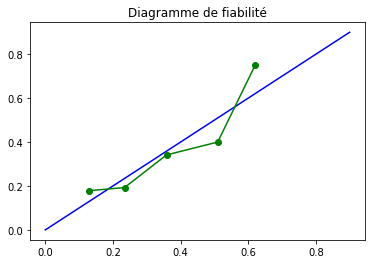

In [ ]:
# on construit le diagramme 
#en faisant apparaitre la diagonale

#et en ajoutant notre diagramme

#titre
plt.title("Diagramme de fiabilit√©")
#trac√©
plt.show()


les points sont tout de m√™me √©loign√©s de la bissectrice, le mod√®le peut √™tre am√©lior√©

## 7. Evaluation des performances du mod√®le √† l'aide de la courbe ROC

Pour √©valuer un mod√®le le taux d‚Äôerreur semble √™tre un indicateur synth√©tique pertinent, il indique (estime) la probabilit√© de mal classer un individu de la population.
Les autres indicateurs sont tr√®s int√©ressants √©galement (sensibilit√©/rappel,pr√©cision/sp√©cificit√©) mais obligent √† surveiller plusieurs valeurs simultan√©ment.

Mais lorsque les classes sont tr√®s d√©s√©quilibr√©es, la matrice de confusion et surtout le
taux d‚Äôerreur donnent souvent une fausse id√©e de la qualit√© de l‚Äôapprentissage. Do√π l'int√©r√™t de la courbe ROC!
les r√©sultats qu'elle fournit sont valables m√™me si l'√©chantillon n'est pas repr√©sentatif

cas du mod√®le qui ne fait pas mieux que l‚Äôaffectation des probabilit√©s
- notre courbe ne doit pas passer en dessous
- plus il s‚Äôen √©carte vers le haut, mieux c‚Äôest

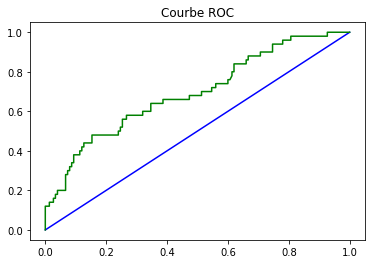

In [ ]:
# on utilise roc_curve (scikit- learn )
# on trace la diagonale de r√©f√©rence
#fpr (false positive rate -- taux de faux positifs) en abscisse
#tpr (true positive rate ‚Äì taux de vrais positifs) en ordonn√©e
#pos_label = 1 pour indiquer la modalit√© cible


In [ ]:
# on calcule l'aire sous la courbe en faisant appel √† la fonction roc_auc_score()


AUC : 0.6934


## 8. Ajustement du mod√®le

## 9. Selection des variables au regard de leur significativit√© : approche statistique 

### Via le test du rapport de vraisemblance